# Removal of cell-cycle and sex covariates


We show consider a dataset of Drosophila myoblasts [[1]](https://doi.org/10.7554/eLife.61276). We show that that conditioning on the gene expression from cell sex and cell cycle marker genes `SiFT` is able to deconfound cell sex and cell cycle effects while preserving signal from the other genes.

[[1] Everetts, N. J., Worley, M. I., Yasutomi, R., Yosef, N., & Hariharan, I. K. (2021). Single-cell transcriptomics of the Drosophila wing disc reveals instructive epithelium-to-myoblast interactions. Elife, 10, e61276.](https://doi.org/10.7554/eLife.61276)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scvi
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import time
from scipy.sparse import issparse

import sift

Global seed set to 0
/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR


## Set Parameteres

In [4]:
DATA_DIR = DATA_DIR / "nuisance_drosophila"
FIG_DIR = FIG_DIR / "nuisance_drosophila"

In [5]:
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

/tmp/ipykernel_8597/466775981.py:47: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [6]:
method_colors = ["#5C88DAFF", "#84BD00FF", "#FFCD00FF", "#7C878EFF"] 
coupled_method_colors = ["#5C88DAFF", "#5C88DA99", "#84BD00FF",  "#84BD0099", "#FFCD00FF", "#7C878EFF"]

## Helper functions

### Set adata colors

In [7]:
def set_adata_colors(adata):
    # set sex
    adata.uns["sex_colors"] = list(sns.color_palette("colorblind", 2).as_hex()[::-1])
    
    # set phase
    adata.obs["phase"] = adata.obs["phase"].astype("category")
    adata.obs["phase"] = adata.obs["phase"].cat.reorder_categories(['G1',  'S', 'G2M'])
    
    colors_ = list(sns.color_palette("Paired", 6).as_hex())
    adata.uns["phase_colors"] = [colors_[1], colors_[3], colors_[5]]
    
    # set batch
    adata.obs["batch_str"] = adata.obs["batch"].copy()
    adata.obs["batch_str"] = adata.obs["batch_str"].cat.rename_categories({
        '96hr_1': "96hr (1)", 
        '96hr_2': "96hr (2)", 
        '120hr_1': "120hr (1)", 
        '120hr_2': "120hr (2)", 
    })
    adata.uns["batch_str_colors"] = ["#92aeb3", "#c9c89d", "#999999", "#392b2b"]

    # set phase-sex
    adata.obs["phase_sex"] = adata.obs["phase"].astype(str) + "_" + adata.obs["sex"].astype(str)
    adata.obs["phase_sex"] = adata.obs["phase_sex"].astype("category")
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.reorder_categories([
        'G1_female',  'G1_male', 
        'S_female',  'S_male', 
        'G2M_female',  'G2M_male', 
    ])
    adata.obs["phase_sex"] = adata.obs["phase_sex"].cat.rename_categories({
        'G1_female' : "G1 (f)",  
        'G1_male': "G1 (m)",
        'S_female': "S (f)",  
        'S_male': "S (m)",
        'G2M_female': "G2M (f)",
        'G2M_male': "G2M (m)", 
    })
    adata.uns["phase_sex_colors"] = list(sns.color_palette("Paired", 6).as_hex())
    

    
    return adata

## Setting parameteres

In [8]:
# list of sex genes and cell cycle genes we will be conditioning on
sex_genes = ["lncRNA:roX1", "lncRNA:roX2", "Sxl", "msl-2"]

cell_cycle_genes = ['PCNA', 'dnk', 'RnrS', 'RnrL', 'Claspin', 'Mcm5', 'Caf1-180',
       'RPA2', 'HipHop', 'stg', 'Mcm6', 'dup', 'WRNexo', 'Mcm7', 'dpa',
       'CG10336', 'Mcm3', 'Mcm2', 'RpA-70', 'Chrac-14', 'CG13690', 'RPA3',
       'asf1', 'DNApol-alpha73', 'CycE', 'DNApol-alpha50',
       'Kmn1', 'Lam', 'Nph', 'msd5', 'msd1', 'ctp', 'Set', 'scra',
       'Chrac-16', 'ncd', 'Ote', 'pzg', 'HDAC1', 'nesd', 'tum', 'CG8173',
       'aurB', 'feo', 'pav', 'CG6767', 'sip2', 'Det', 'Cks30A', 'CycB',
       'B52']

# list of genes we're interested in
genes_of_interest = [
    "Argk",
    "Nrt",
    "Ten-a",
    "Ten-m",
    "wb",
    "Act57B",
    "drl",
    "mid",
    "nemy",
    "lms",
    "CG11835",
    "Gyg",
    "ara",
    "tok",
    "kirre",
    "NK7.1",
    "fj",
    "beat-IIIc",
    "CG33993",
    "dpr16",
    "CG15529",
    "CG9593",
    "beat-IIb",
    "robo2",
    "Ama",
    "fz2",
    "elB",
    "noc",
    "nkd",
    "fng",
    "vg",
]

nuisance_genes = sex_genes + cell_cycle_genes

library_size = 5000

## Pre-process data

In [9]:
# setting up anndata
adata = sc.read("/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/cellcycle_myoblasts/data/myoblasts.h5ad")
# adata = sc.read(DATA_DIR / 'myoblasts.h5ad')

In [10]:
adata.layers['counts'] = adata.X.copy() # move count data into a layer
sc.pp.normalize_total(adata, target_sum = library_size)
sc.pp.log1p(adata) # log the data for better umap visualization later
adata.raw = adata

**Classify the `sex`**

based on the classification performed by Everetts et. al. [[1]]((https://doi.org/10.7554/eLife.61276)) (see [cell_sex_and_cell_cycle_correction.R](https://github.com/HariharanLab/Everetts_Worley_Yasutomi/blob/e1d1f10fefdab11688ad4ca0b8c2684ed47faa0c/scVI/cell_sex_and_cell_cycle_correction.R))

_We expect the data for sex genes to be bimodal, and use the minimum between peaks as a cutoff for determining male and female cells. This usually corresponds to the second extrema in the density (from left to right). However, noise and drop-outs in the data may make this difficult to calculate, so a manual cutoff may be needed instead._
  

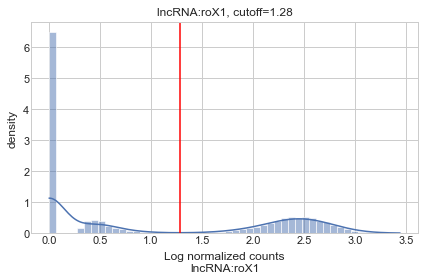

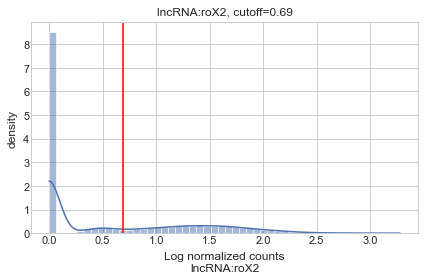

Number of predicted male cells: 8114, percentage from data: 0.41
Number of predicted female cells: 11771, percentage from data: 0.59


In [11]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import vectors

stats = importr("stats")

sex_gene_cutoff = {}
data_density = {}
sex_threshold_cells = {}
sex_genes = ["lncRNA:roX1", "lncRNA:roX2"]

# get density estimate

for i, gene in enumerate(sex_genes):
    column = vectors.FloatVector(adata[:, gene].X)
    data_density[gene]  = stats.density(column, adjust = 2)
    x = np.asarray(data_density[gene][0])
    y = np.asarray(data_density[gene][1])
    # find the second extrema in the density, and use this as a cutoff for cells
    sex_gene_cutoff[gene] = x[np.where(np.diff(np.diff(y) > 0))][1]
    adata.obs[f"{gene}_cutoff"] = adata[:, gene].X >= sex_gene_cutoff[gene]
    
    ax = sns.histplot(adata[:, gene].X, stat="density", bins=50, kde=True)
    ax.legend().remove()
    ax.set_xlabel(f"Log normalized counts\n{gene}")
    ax.set_ylabel(f"density")
    plt.axvline(x=sex_gene_cutoff[gene],color='red')
    plt.title(f"{gene}, cutoff={sex_gene_cutoff[gene]:.2f}")
    
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"sex_cutoff_{gene}.png", bbox_inches="tight", dpi=DPI)
    plt.show()
    
adata.obs["sex"] = "female"
adata.obs.loc[adata.obs["lncRNA:roX1_cutoff"] | adata.obs["lncRNA:roX2_cutoff"], "sex"]  = "male"


num_male = (adata.obs["sex"] == "male").sum()
num_female = (adata.obs["sex"] == "female").sum()
print(f"Number of predicted male cells: {num_male}, percentage from data: {num_male/(num_male+num_female):.2f}")
print(f"Number of predicted female cells: {num_female}, percentage from data: {num_female/(num_male+num_female):.2f}")

Classify cell cycle based on cell cycle genes from Kirchner [Drosophila_melanogaster.csv](https://github.com/hbc/tinyatlas/blob/master/cell_cycle/Drosophila_melanogaster.csv) as used in Zhu et al. [[2]](https://doi.org/10.1038/s41467-022-28915-3)

[[2] Kiat, Y., Vortman, Y., & Sapir, N. (2019). Feather moult and bird appearance are correlated with global warming over the last 200 years. Nature Communications, 10(1), 1-7.](https://doi.org/10.1038/s41467-022-28915-3)


In [12]:
g2m_genes = [
    'Mps1', 'aurA', 'CycB', 'fzy', 'twe', 'pbl', 'RanGAP', 'stg',
    'sub', 'Su(var)205', 'Cdk1', 'Klp61F', 'pie', 'pav', 'glu', 'msps',
    'pigs', 'Nek2', 'HP1b', 'Phf7', 'Bub1', 'mars', 'Mapmodulin',
    'LBR', 'CTCF', 'Cks85A', 'HP1e', 'HP1c', 'Cap-D2', 'cmet', 'cana',
    'scra', 'BubR1', 'Det', 'vih', 'Dsp1', 'Top2'
]
s_genes = [
    'Blm', 'spn-A', 'PCNA', 'CycE', 'RnrS', 'DNApol-alpha50',
    'l(2)dtl', 'Mcm2', 'spel1', 'tos', 'dpa', 'Mcm5', 'Ts', 'Mcm6',
    'Fen1', 'Cdc45', 'Usp1', 'CG15141', 'CG10336', 'PCNA2', 'RPA2',
    'Caf1-105', 'CG11788', 'Cdc6', 'Slbp', 'Claspin',
    'DNApol-alpha180', 'RfC4', 'Psf2'
]

In [13]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [14]:
adata = set_adata_colors(adata)

In [15]:
adata_nothing = adata.copy()

In [16]:
sc.pp.scale(adata_nothing)
sc.tl.pca(adata_nothing)
sc.pp.neighbors(adata_nothing)
sc.tl.umap(adata_nothing)

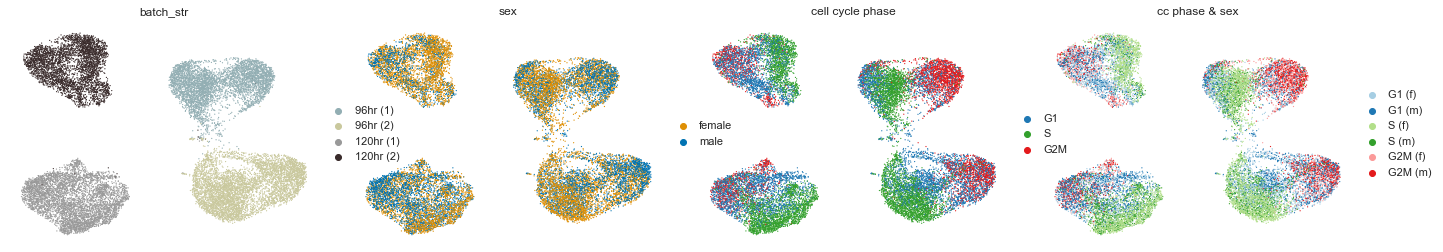

In [17]:
fig = sc.pl.umap(
        adata_nothing,
        color=["batch_str", "sex",  "phase", "phase_sex"],
        frameon=False,
        wspace=0,
        return_fig=True,
    )
fig.axes[2].set_title("cell cycle phase")
fig.axes[3].set_title("cc phase & sex")
plt.show()

In [18]:
adata = adata[adata.obs["phase_sex"].argsort(), :]

In [19]:
adata_nothing = adata_nothing[adata_nothing.obs["phase_sex"].argsort(), :]

In [20]:
adata_nothing.write(DATA_DIR / "myoblasts_nothing.h5ad")

In [21]:
adata.write(DATA_DIR / "myoblasts_annotated.h5ad")

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## Read pre-processed `adata`

In [22]:
methods = ["sift", "regress_out", "scvi_cond", "nothing"]
fnames = {method: f"myoblasts_{method}.h5ad" for method in methods}

In [ ]:
adata = sc.read(DATA_DIR / "myoblasts_annotated.h5ad")

In [23]:
adatas_ = {}

# `SiFT`

In [24]:
metric = "knn"
method = methods[0]
n_neighbors = 3

In [25]:
# setting up anndata for sift

adatas_[method] = adata.copy()

# then copy the expression of the nuisance gene into adata.obsm
adatas_[method].obsm["nuisance_genes"] = adatas_[method][:, nuisance_genes].X
adatas_[method].uns["nuisance_genes"] = nuisance_genes


# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()


In [26]:
start = time.perf_counter()

print(f"running {method}")    
kernel_key_ =  "nuisance_genes"     

sft = sift.SiFT(
    adata=adatas_[method],
    kernel_key=kernel_key_,
    n_neighbors=n_neighbors,
    metric=metric,
    copy=False,
)
sft.filter(
    embedding_key="X",
    pseudocount=True
    )
compute_time = time.perf_counter() - start
print(f"{method} finished in {compute_time} sec")


running sift
INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
sift finished in 1.9648119201883674 sec


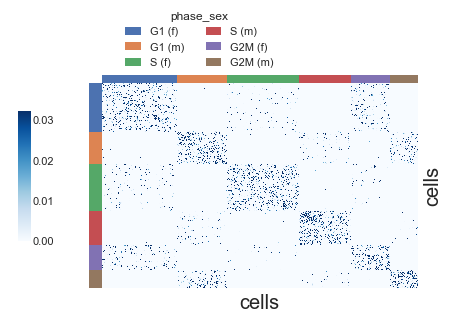

In [27]:
fig = sft.plot_kernel(
    groupby="phase_sex",
    cmap="Blues",
    show=False,
)
    
plt.show()

In [28]:
sc.tl.pca(adatas_[method],)
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

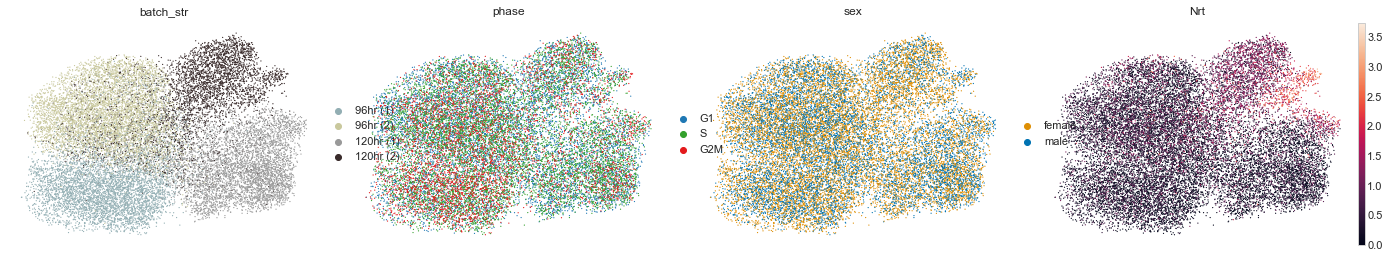

In [29]:
sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "Nrt"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()    

In [30]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# `regress_out` (`Scanpy`)

We run scanpy's `regress_out()` as a baseline.

In [31]:
method = methods[1]

In [32]:
# setting up anndata for scvi with conditioning on nuisance genes
adatas_[method] = adata.copy()

# then copy the expression of each nuisance gene into adata.obs where the key
# is the gene name
for g in nuisance_genes:
    exp = adatas_[method][:, g].X
    adatas_[method].obs[g] = exp.copy()

    
# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:, gene_subset].copy()

In [33]:
# takes ~ 15 min to run 
print(f"running `regress_out`")
start = time.perf_counter()

adatas_[method] = sc.pp.regress_out(adatas_[method], nuisance_genes, copy=True)

compute_time = time.perf_counter() - start
print(f"`regress_out` finished in {compute_time} sec")

running `regress_out`
`regress_out` finished in 386.5356504120864 sec


In [34]:
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

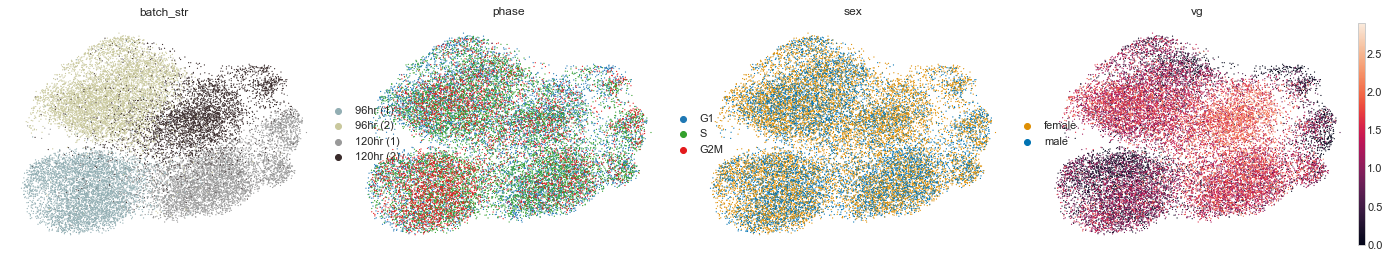

In [35]:
sc.pl.umap(
    adatas_[method],
    color=["batch_str", "phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()

In [ ]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# scVI (only extra covariates)

We train scVI on extra categorical covariates. 

In our case, we would like to condition our latent represenation on cell cycle and cell sex gene expression in order to learn a latent representation that is independant of cell sex and cell cycle. 

In [36]:
method = methods[2]

In [37]:
# setting up anndata for scvi with conditioning on nuisance genes
adatas_[method] = adata.copy()

# then copy the expression of each nuisance gene into adata.obs where the key
# is the gene name
for g in nuisance_genes:
    exp = adatas_[method][:,g].X
    adatas_[method].obs[g] = exp.copy()

# finally, remove the nuisance genes from the anndata
gene_subset = [g for g in adatas_[method].var_names if g not in nuisance_genes]
adatas_[method] = adatas_[method][:,gene_subset].copy()

# run setup_anndata with our list of nuisance genes as our continuous covariates
scvi.model.SCVI.setup_anndata(adatas_[method],
                              continuous_covariate_keys=nuisance_genes, 
                              layer='counts')

## Train

In [38]:
cond_model = scvi.model.SCVI(adatas_[method])

In [39]:
cond_model.train()

Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██| 400/400 [05:57<00:00,  1.11it/s, loss=2.56e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [05:57<00:00,  1.12it/s, loss=2.56e+03, v_num=1]


## Visualization
Here we visualize the latent space of our `scVI` model trained with expression from our nuisance genes as a continuous covariate.

In [40]:
adatas_[method].obsm["X_emb"] = cond_model.get_latent_representation()
adatas_[method].layers["X"] =  adatas_[method].X.copy()
adatas_[method].layers["X_scvi_norm"] = cond_model.get_normalized_expression(adatas_[method], library_size = library_size)

In [41]:
# log1p scvi normalized expression
adatas_[method].layers["scvi_norm_log"] = np.log1p(adatas_[method].layers["X_scvi_norm"])
# set layer to scvi_norm_log prior to scaling and clustering
adatas_[method].X = adatas_[method].layers["scvi_norm_log"]

In [42]:
# scale expression
sc.pp.scale(adatas_[method])

In [43]:
sc.pp.neighbors(adatas_[method], use_rep = "X_emb")
sc.tl.umap(adatas_[method])

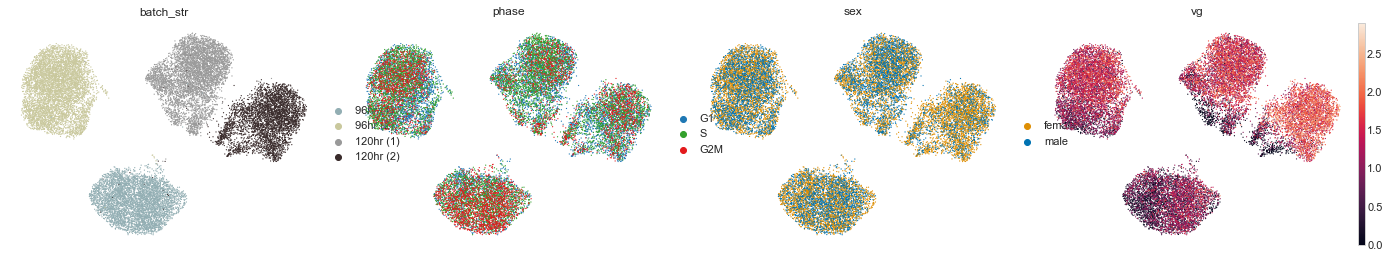

In [44]:
fig = sc.pl.umap(
    adatas_[method],
    color=["batch_str", "phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
    )

plt.show()

In [45]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Nothing

In [46]:
method = methods[3]

In [47]:
adatas_[method] = adata.copy()
sc.pp.scale(adatas_[method])
sc.tl.pca(adatas_[method])
sc.pp.neighbors(adatas_[method])
sc.tl.umap(adatas_[method])

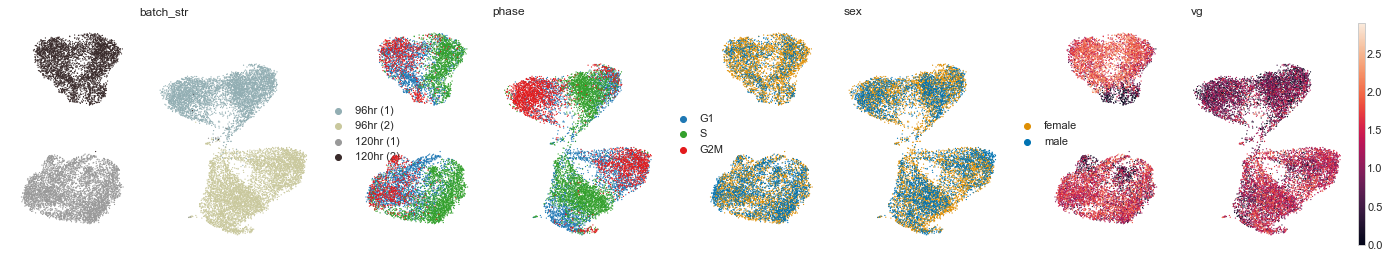

In [48]:
fig = sc.pl.umap(
    adatas_[method],
    color=["batch_str","phase", "sex", "vg"],
    frameon=False,
    wspace=0,
    return_fig=True,
)
plt.show()

In [49]:
adatas_[method].write(DATA_DIR / f"myoblasts_{method}.h5ad")

# Analysis

## Import data

In [50]:
import scib

In [51]:
methods = ["sift", "regress_out", "scvi_cond", "nothing"]

In [ ]:
adatas_ = {}

In [ ]:
for method in methods:
    adatas_[method] = sc.read(DATA_DIR / f"myoblasts_{method}.h5ad")

## Plot data

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


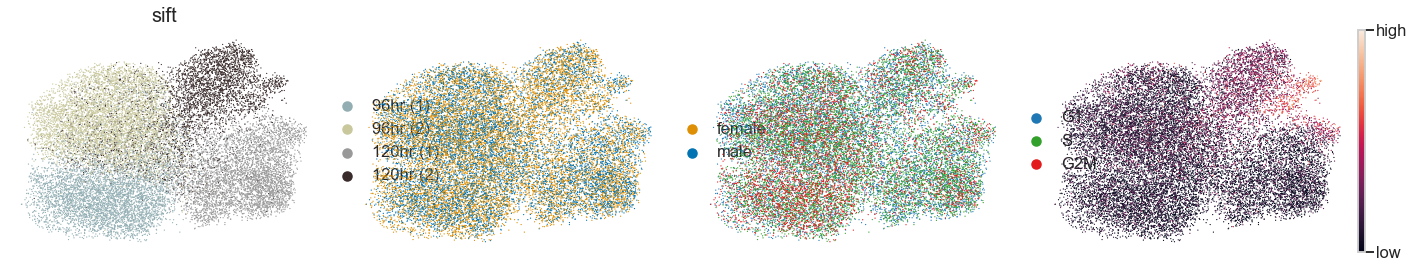

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


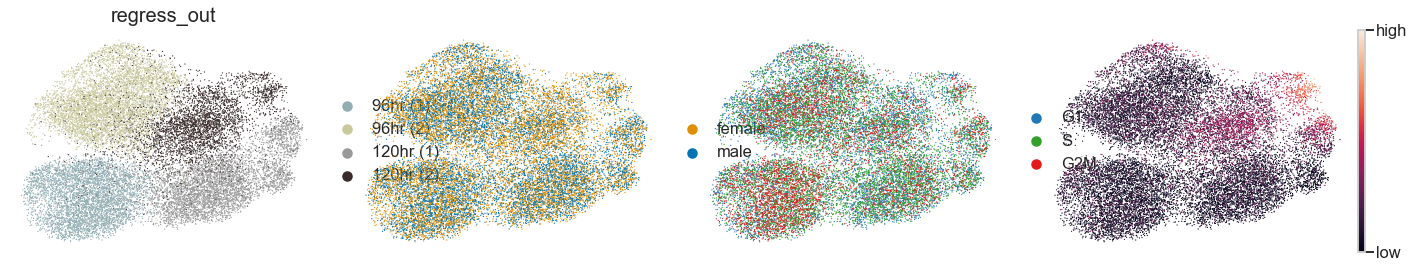

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


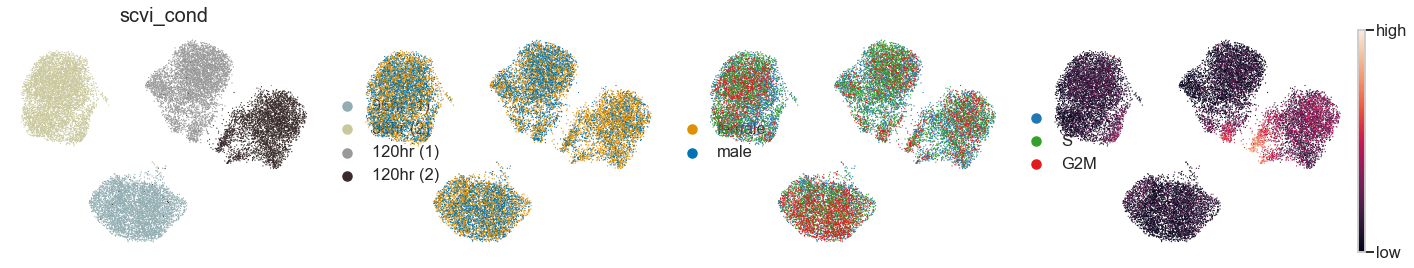

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


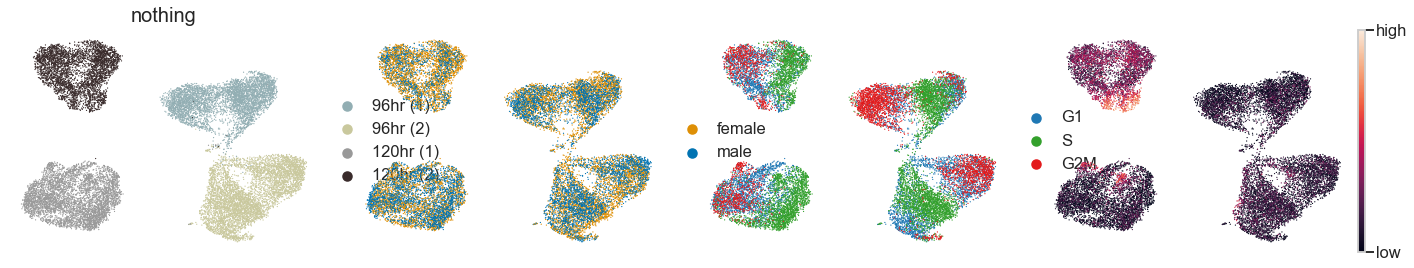

In [52]:
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    fig = sc.pl.umap(
        adata_,
        color=["batch_str", "sex",  "phase", "Nrt"],
        frameon=False,
        wspace=0,
        return_fig=True,
    )
    
    for ax in fig.axes:
        ax.set_title("")
    fig.axes[0].set_title(key_, fontsize=20)
    g = fig.axes[-1].get_yaxis()
    g.set_ticks([0, 3.74])
    g.set_ticklabels(["low", "high"])
    fig.savefig(FIG_DIR / f"dros_{key_}_umap.png", bbox_inches="tight", dpi=DPI)
    plt.show()

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


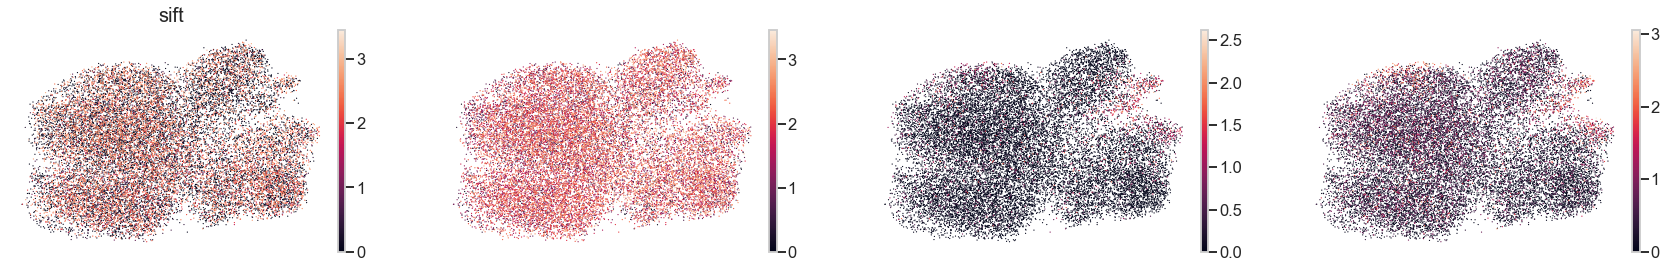

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


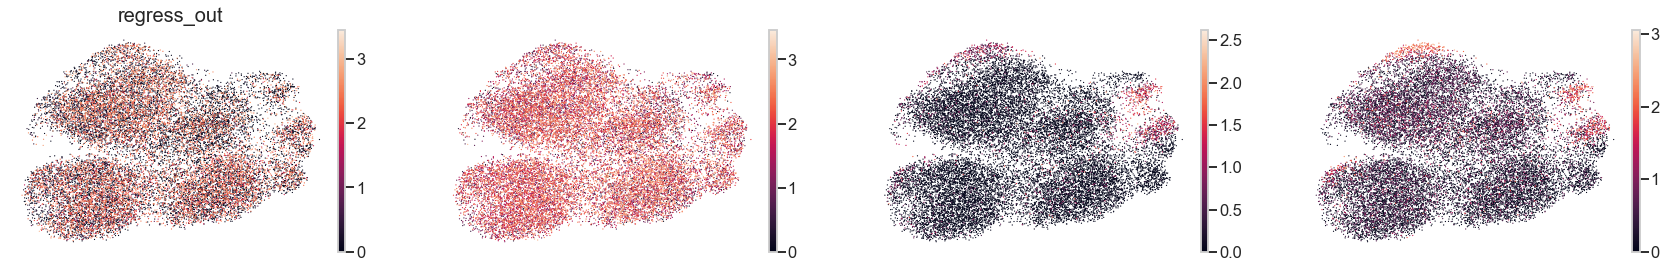

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


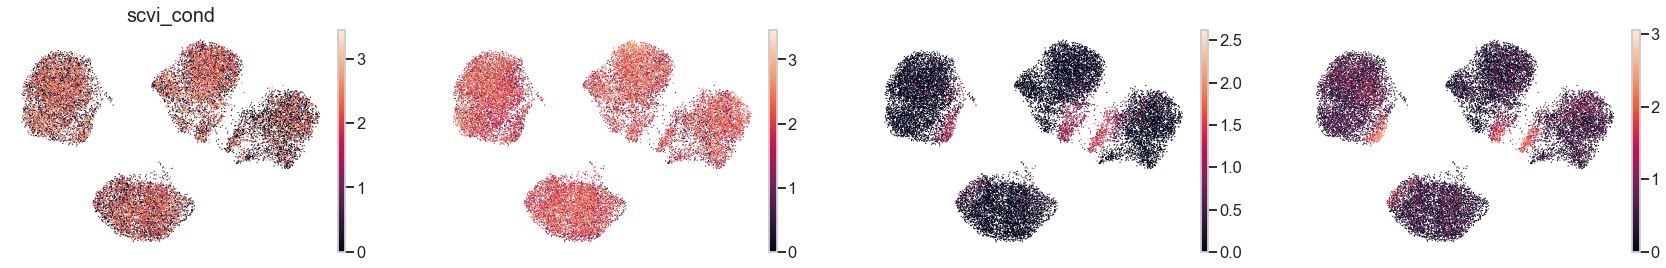

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


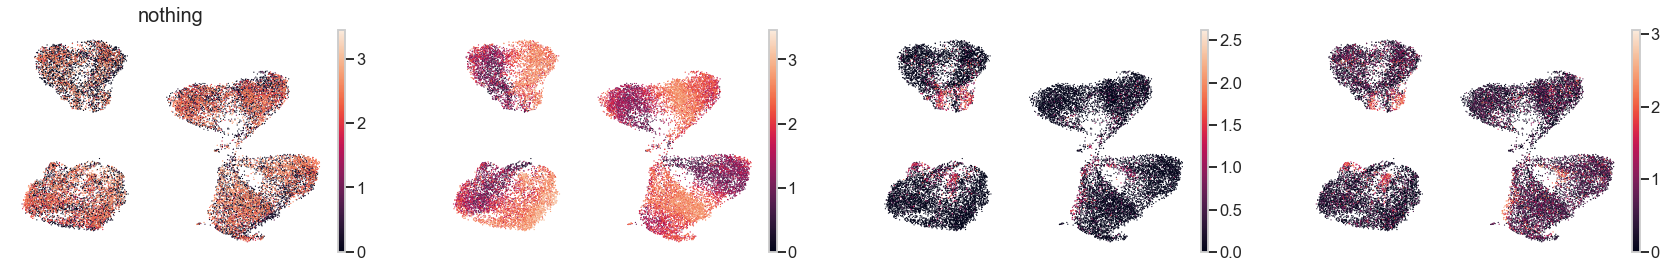

In [53]:
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    fig = sc.pl.umap(
        adata_,
        color=[ "lncRNA:roX1", "PCNA", "mid", "ptc",],
        frameon=False,
        wspace=0.2,
        return_fig=True,
    )
    for ax in fig.axes:
        ax.set_title("")
    fig.axes[0].set_title(key_, fontsize=20)
    fig.savefig(FIG_DIR / f"dros_{key_}_cov_genes_umap.png", bbox_inches="tight", dpi=DPI)
    plt.show()

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


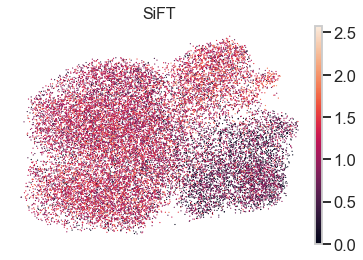

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


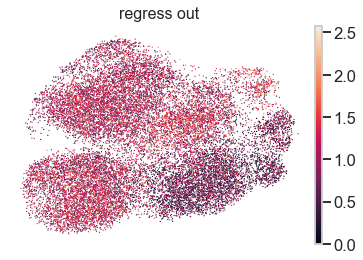

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


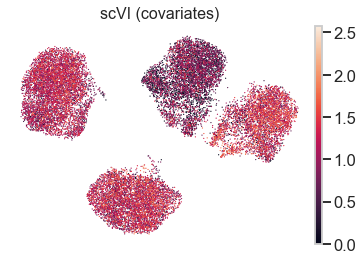

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


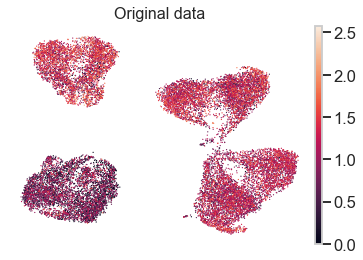

In [54]:
titles= { 
    'sift': "SiFT",
    'scvi_cond':'scVI (covariates)', 
    'regress_out': 'regress out', 
    'nothing' : 'Original data', 
}

gene = "htl"
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    if key_ in titles:
        fig = sc.pl.umap(
            adata_,
            color=[gene],
            title=titles[key_],
            frameon=False,
            return_fig=True,
        )
        fig.axes[0].set_title(titles[key_], fontsize=16)
        fig.savefig(FIG_DIR / f"dros_{key_}_{gene}_umap.png", bbox_inches="tight", dpi=DPI)
        plt.show()

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


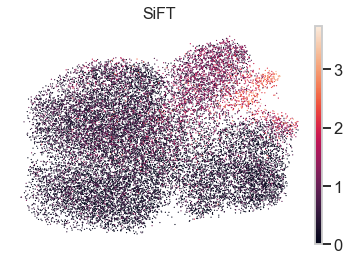

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


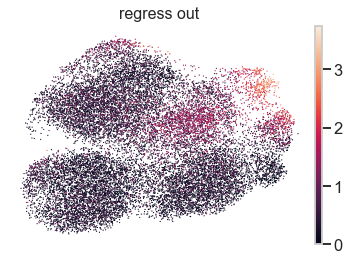

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


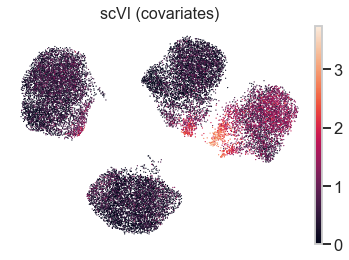

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


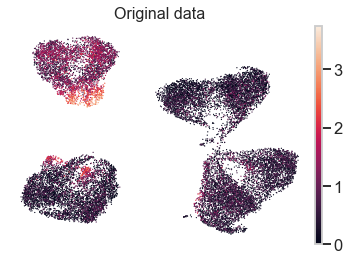

In [55]:
titles= { 
    'sift': "SiFT",
    'scvi_cond':'scVI (covariates)', 
    'regress_out': 'regress out', 
    'nothing' : 'Original data', 
}

gene = "Nrt"
for key_, adata_ in adatas_.items():
    adata_ = set_adata_colors(adata_)
    if key_ in titles:
        fig = sc.pl.umap(
            adata_,
            color=[gene],
            title=titles[key_],
            frameon=False,
            return_fig=True,
        )
        fig.axes[0].set_title(titles[key_], fontsize=16)
        fig.savefig(FIG_DIR / f"dros_{key_}_{gene}_umap.png", bbox_inches="tight", dpi=DPI)
        plt.show()

## Quantitive analysis - `iLISI graph score` and `hvg`s

In [56]:
metrics_eval = ["ilisi",]
batch_keys = ["phase","phase_sex"]

scores = {}
for metric_ in metrics_eval:
    for key_ in batch_keys:
        scores[f"{metric_}_{key_}"]  = {}

scores["hvg"] = {}

In [57]:
n_hvg = 500

methods_cmp = {
    'sift': "SiFT",
    'regress_out': "regress_out", 
    'scvi_cond': "scVI", 
    'nothing' : 'Original data', 
}

In [58]:
for method in methods_cmp:
    print(f"eval {method}")
    cc = sc.pp.highly_variable_genes(
            adatas_[method], 
            n_top_genes=n_hvg,
            flavor = "cell_ranger",
            inplace=False
        )
    hvgs_ = adatas_[method].var_names[cc["highly_variable"]]
        
    intersect_hvg_ = hvgs_.intersection(genes_of_interest)
    scores["hvg"][f"{method}"] = len(intersect_hvg_) / len(genes_of_interest)
    score_ = scores["hvg"][f"{method}"]
    print(f"hvg score: {score_}")
    
    for batch_key in batch_keys:
        print(f"{method}-{batch_key}")
        
        # iLISI
        params = {
            "adata": adatas_[method],
            "batch_key": batch_key,
            "type_": "embed" if "X_emb" in adatas_[method].obsm else "full",
            "n_cores": 1,
            "subsample": 0.5 * 100,
        }
        
        scores[f"ilisi_{batch_key}"][f"{method}"] = scib.metrics.ilisi_graph(
            **params
        )
        score_ = scores[f"ilisi_{batch_key}"][f"{method}"]
        print(f"iLISI score: {score_}")
        
        

eval sift
hvg score: 0.4838709677419355
sift-phase
iLISI score: 0.771290503806203
sift-phase_sex
iLISI score: 0.633284783890055
eval regress_out
hvg score: 0.22580645161290322
regress_out-phase
iLISI score: 0.7541317841226443
regress_out-phase_sex
iLISI score: 0.6197340247262689
eval scvi_cond
hvg score: 0.25806451612903225
scvi_cond-phase
iLISI score: 0.70365404351982
scvi_cond-phase_sex
iLISI score: 0.5964644521906004
eval nothing
hvg score: 0.0967741935483871
nothing-phase
iLISI score: 0.33683027146333044
nothing-phase_sex
iLISI score: 0.3037108162314356


In [59]:
df_scores = pd.DataFrame(scores).T
df_scores = df_scores.reset_index()
df_scores = df_scores.melt(id_vars=["index",]).rename(columns = {'index':'metric', 'value':'score'}, inplace = False)
df_scores["variable"] = df_scores["variable"].replace(methods_cmp)

### Save score

In [60]:
df_scores.to_csv(DATA_DIR / "ilisi_hvg_scores.csv")

### Plot score

In [61]:
df_scores = pd.read_csv(DATA_DIR / "ilisi_hvg_scores.csv")

In [62]:
methods_plot = {
    'sift': "SiFT",
    'regress_out': "regress_out", 
    'scvi_cond': "scVI", 
    'nothing' : 'Original data', 
}

In [63]:
df_scores.loc[:, "variable"] = df_scores.loc[:, "variable"].replace({"scVI (covariates)":"scVI"})

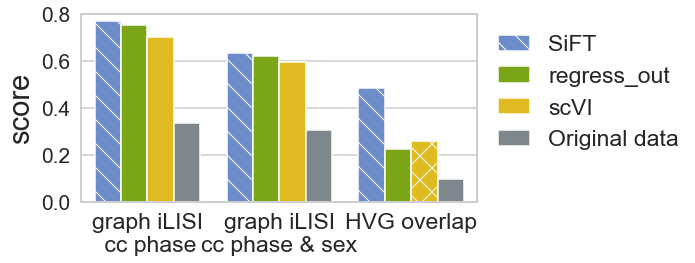

In [64]:
label_title = {"phase":"graph iLISI\n cc phase", "phase_sex": "graph iLISI\ncc phase & sex", "hvg": "HVG overlap"}

size = 4
fig, axs = plt.subplots(1,1, figsize=(size*2.5, size))


metrics_plot =  [f"ilisi_{label}" for label in ["phase", "phase_sex"]] 
metrics_plot.append("hvg")

df_scores_lim = df_scores[df_scores["metric"].isin(metrics_plot)].copy()
df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        f"ilisi_{label}": label_title[label] for label in ["phase", "phase_sex"]
        
    }, inplace=False)

df_scores_lim.loc[:, "metric"] = df_scores_lim.loc[:, "metric"].replace({
        "hvg": "HVG overlap"
        }, inplace=False)

df_scores_lim = df_scores_lim[df_scores_lim["variable"].isin(methods_plot.values())]
df_scores_lim



bar = sns.barplot(x="metric", y="score", data=df_scores_lim, hue="variable", ax=axs, palette=method_colors)
# Define some hatches
hatches = ['\\', '\\', '\\',
              '', '', '', 
           '', '', 'x','', '', '',]

# Loop over the bars
for i, thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
        
leg = axs.legend(ncol=1, 
                    loc="upper left", 
                    bbox_to_anchor=(1.0, 1.0),
                    frameon=False, fontsize=fontsize-2)
plt.title("")
plt.xticks(rotation=0,  fontsize=fontsize-2)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8] ,fontsize=fontsize-4)
plt.xlabel("", fontsize=fontsize-4)
plt.ylabel("score",  fontsize=fontsize+4)
plt.tight_layout()
fig.savefig(FIG_DIR / f"score_iLISI_hvg.png", bbox_inches="tight", dpi=DPI)
plt.show()